In [1]:
from StockMarket2 import *
from functools import partial
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
market_data = list(read_market_data())

# Cash Cushions and Ratcheting Withdrawals

As I neared retirement, I did a lot of research on how much of my portfolio I could withdraw in a given year (or, conversely, how large a portfolio I'd need to sustain a given income).  Of course I came across the "4% Safe Withdrawal Rate."  And that the S&P 500's long-term compound annual growth rate (CAGR) is about 7% after inflation.

The natural question was why is the Safe Withdrawal Rate so much less than the S&P 500's inflation-adjusted CAGR?  That's because you might retire right before the start of a major downturn, and end up having to sell a larger percentage of your portfolio while the market is down (thus having a smaller portfolio left when the market recovers and keeps growing).

Yet, most of the time (when retirement didn't start with a major downturn), the 4% SWR results in the portfolio's inflation-adjusted value growing over time -- often significantly.  So, most of the time, you should be able to either get away with a larger initial withdrawal, or else increase your withdrawals by more than inflation, and still not run out of money.

I has also heard many recommendations to have 3 to 5 years of expenses out of the stock market (a "cash cushion"), so that you're not forced to sell stocks during the depths of a downturn.  Such a strategy should make it less likely that you run out of money for a given withdrawal rate, or let you increase the withdrawal rate with a similar chance of running out of money.

I set out to find a way to safely increase retirement withdrawals.  And, since I retired early, I wanted to see what a "safe" withdrawal rate would be for a 40-year retirement (instead of the typical 30 years).  I wrote some code to simulate retirement periods, using Robert Shiller's historical stock market data from his book _Irrational Exuberance_.  I wanted to be able to evaluate various strategies for asset allocation and adjusting the withdrawal amount over time, as well as the duration of retirement.

## Summary

Phoenix 1's 10% raise rule does not significantly impact survivability or sustainability of the portfolio, nor does it significantly increase withdrawals.  Adjusting ("ratcheting") the withdrawal to match the initial withdrawal rate significantly increases withdrawals at the expense of survivability and sustainability of the portfolio.  Adding a cash cushion of 3 to 5 years of withdrawals significantly improves survivability of a portfolio with ratcheting withdrawals, while still allowing withdrawals to grow significantly over time (though somewhat less than without the cash cushion).

## Methodology

My simulations are based on historical stock market data compiled and published by Robert Shiller.  This consists of monthly data from 1871 to present for S&P 500 price, dividends, and Consumer Price Index (to track inflation), plus other data.  I simulated the value of the portfolio over time, quarterly withdrawals and annual adjustments to the withdrawal amount.  Dividends were computed and reinvested quarterly.  The portfolio was 100% invested in stocks, unless a "cash cushion" was being simulated.  I used 3-month Treasury Bill yields (1934 to present) as an estimate for interest earned on cash (when a cash cushion was used).

## Terminology

I decided to focus on a few key statistics for evaluating a particular strategy.

**Survivability** is whether the portfolio is able to make all of the withdrawals for the given length of retirement.  If it runs out of money early, then it is not survivable.  I express it as the percentage of potential retirement periods that actually had enough money to make all of their withdrawals.

**Sustainability** is whether the portfolio's ending inflation-adjusted value is close enough to its starting value, so it could likely provide withdrawals for much longer periods (possibly indefinitely).  I express it as the percentage of potential retirement periods where the ending value is at least 95% of the initial value, after adjusting for inflation.

**Balance Growth**.  I calculated the median, mean, and standard deviation of the portfolio's inflation-adjusted compound annual growth rate for all periods simulated.  A positive growth rate means the portfolio grew by more than inflation over the retirement period.

**Withdrawal Growth**.  I calculated the median, mean and standard deviation of the withdrawal's inflation-adjusted compound annual growth rate for all periods simulated.  A positive value means that the withdrawl amount grew by more than inflation over the retirement period.

## Baseline

As a baseline, I started with a 30-year retirement period and a 4% initial withdrawal rate as suggested by William Bengen.  As a stock-loving Fool, the baseline is a portfolio that is 100% invested in the S&P 500, with dividends reinvested quarterly.  Withdrawals are made quarterly.  The withdrawal amount is adjusted annually by the change in the Consumer Price Index (inflation).

Here are the statistics for that baseline:

    survivability:  98.36%
    sustainability: 83.06%
    balance     median:  3.64%  mean:  3.11%  stdev:  3.30%
    withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%

In [3]:
portfolio = Portfolio()

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.36%
sustainability: 83.06%
balance     median:  3.64%  mean:  3.11%  stdev:  3.30%
withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%


In [4]:
[period.date for period in periods if not period.survived]

[datetime.date(1929, 1, 1),
 datetime.date(1929, 2, 1),
 datetime.date(1929, 3, 1),
 datetime.date(1929, 4, 1),
 datetime.date(1929, 5, 1),
 datetime.date(1929, 6, 1),
 datetime.date(1929, 7, 1),
 datetime.date(1929, 8, 1),
 datetime.date(1929, 9, 1),
 datetime.date(1929, 10, 1),
 datetime.date(1930, 3, 1),
 datetime.date(1930, 4, 1),
 datetime.date(1930, 5, 1),
 datetime.date(1965, 10, 1),
 datetime.date(1965, 11, 1),
 datetime.date(1965, 12, 1),
 datetime.date(1966, 1, 1),
 datetime.date(1966, 2, 1),
 datetime.date(1968, 6, 1),
 datetime.date(1968, 9, 1),
 datetime.date(1968, 10, 1),
 datetime.date(1968, 11, 1),
 datetime.date(1968, 12, 1)]

What this means is that 98.36% of all 30-year periods "surived".  That is, the portfolio was able to make all 120 quarterly withdrawals.  In the other 1.64% of periods, the portfolio ran out of money in less than 30 years.

In 83.06% of periods, the portfolio's ending value was at least 95% of the initial value, adjusted for inflation.  The portfolio could probably last at least another 30 years.

In the other 6.94% of periods, the ending value was less.  This is typically due to a significant market decline at the start of the retirement period, or a decline right near the end of the retirement period.

(**_TODO_**) Distribution of the ending value relative to the inflation-adjusted initial value?

As you can see, the withdrawal amount grows with inflation.  The withdrawal growth rate is slightly negative because the withdrawal is only adjusted annualy, but the growth rate reflects inflation as of the last quarterly withdrawal.  So you're seeing the effects of the last year's inflation, right before the withdrawal amount would be adjusted again.

The portfolio grew by 3.11% more than inflation, per year, on average.  Since withdrawals grew by inflation, this means the portfolio typically grew significantly more than the withdrawals.  This reflects the difference between the initial withdrawal rate and the long-term growth rate of the S&P 500.

Note that the periods that didn't survive were:
* January through October 1929
* March through May 1930
* October 1965 through February 1966
* June, and September through December 1968

The Great Depression was a brutal decline that lasted 29 years from initial peak to recovery on an inflation-adjusted basis.  The late 1960's saw two large declines with a brief growth spurt in between, and high inflation.  It's worth noting that William Bengen's study wouldn't have included retirement periods starting in the late 1960's because they wouldn't have had 30 years duration (his study was in the 1980's).

## Cash Cushion

Now let's take a look at using a cash cushion.  Foolish advice is that you should have the next 3 to 5 years of expenses out of the stock market so that you're not forced to sell in the depths of a market downturn.

But when and how should you use this cash instead of selling stock?  How large should the cash cushion be?  When and how do you replenish this cash cushion after you have used some of it?  How do you increase it as your portfolio increases?

It seems to me that you want to use cash from the cash cushion during a market decline, ideally at the lowest prices of the decline.  Using the cash cushion at the very beginning of the decline, or near the end of the recovery is less important since stock prices are higher than in the depths of the decline.  But we can't predict the depth or duration of any given decline in advance, not even during the decline itself.  So we have to make a guess.

I chose to start using the cash cushion when the portfolio's value declined to 90% or less of its previous annual maximum value.  Once it drops below that value, withdrawals come first from the cash cushion.  If the remaining cash cushion isn't sufficient, then the balance comes from selling stock.  When the portfolio reaches its previous annual maximum (or sets a new maximum), the cash cushion begins to be rebuilt by selling more stock than is needed to pay that quarter's withdrawal.  I chose to sell (up to) 1.5 times the quarterly distribution.  That is, the cash cushion is increased by (up to) half of the quarterly distribution, each quarter, until it has reached the desired level.

Note that when the annual withdrawal is increased, the previous cash cushion will be insufficient, so this triggers rebuilding the cash cushion even though it wasn't necessarily depleted during a decline.

I chose a target amount of three times the annual withdrawal.  This does not try to adjust for future inflationary adjustments.  So it ends up being a little less than the next three years of withdrawals.

Cash may earn interest.  I don't know of good historical data for interest rates.  I ended up using the 3-month Treasury Bill yield, at least as far back as it goes (to 1934).  Before that, I assume no interest on cash.  This rate seems in the right ballpark for high yield savings or money market accounts.

Later, I'll discuss other values for the size of the cushion, triggering the use of the cash cushion, and the rate at which it is replenished.  It turns out that 3 years, 90% and 1.5x replenishment were pretty good, but not optimal.

In [5]:
portfolio = Portfolio(cash_cushion=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.72%
sustainability: 81.85%
balance     median:  3.20%  mean:  2.71%  stdev:  3.10%
withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%


In [6]:
[period.date for period in periods if not period.survived]

[datetime.date(1929, 7, 1),
 datetime.date(1929, 8, 1),
 datetime.date(1929, 9, 1),
 datetime.date(1929, 10, 1)]

    survivability:  99.72%
    sustainability: 81.85%
    balance     median:  3.20%  mean:  2.71%  stdev:  3.10%
    withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%

Portfolio survivability goes up, relative to the baseline.  It's nearly 100% now.  The only failures were July to October 1929, right before the stock market's biggest crash.

Sustainability is a little lower, and the balance's growth rate is somewhat lower.  These are because cash is typically growing more slowly than stocks.  We've traded some growth for safety.

## Raises

Next, let's consider a rule that grows withdrawals when the market does sufficiently well.  I went with Phoenix 1's 10% rule.  If the portfolio's value is at least 10% higher than its previous annual maximum, then grow the withdrawal by the maximum of 10% and inflation, else just grow it by inflation.

In [7]:
portfolio = Portfolio(raise_enable=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.15%
sustainability: 81.57%
balance     median:  3.51%  mean:  2.91%  stdev:  3.38%
withdrawal  median:  0.21%  mean:  0.25%  stdev:  0.32%


    survivability:  98.15%
    sustainability: 81.57%
    balance     median:  3.51%  mean:  2.91%  stdev:  3.38%
    withdrawal  median:  0.21%  mean:  0.25%  stdev:  0.32%

Survivability and sustainability are slightly lower than the baseline safe withdrawal rate, but very close.  The withdrawal growth rate was slightly higher than inflation.  The portfolio growth rate was a little lower as more of the portfolio was withdrawn.

It turns out that the 10% growth threshold doesn't happen all that often (at least for the S&P 500), so withdrawals mostly grew by inflation.

## Cash cushion and Raises

Now let's look at a combination of both a cash cushion and Phoenix 1 style raises.

    survivability:  99.43%
    sustainability: 80.57%
    balance     median:  3.07%  mean:  2.54%  stdev:  3.14%
    withdrawal  median:  0.15%  mean:  0.19%  stdev:  0.32%

Survivability and sustainability were slightly lower than with just a cash cushion.  Survivability was higher than the baseline.  Withdrawals grew, but less than with just raises.  Portfolio balance grew slightly less than with either cash cushion or raises alone, but still well more than inflation.

In [8]:
portfolio = Portfolio(cash_cushion=True, raise_enable=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.43%
sustainability: 80.57%
balance     median:  3.07%  mean:  2.54%  stdev:  3.14%
withdrawal  median:  0.15%  mean:  0.19%  stdev:  0.32%


## Ratcheting Withdrawals

Now let's try a different way of growing withdrawals.  I call this "ratcheting."  Every time the withdrawal is adjusted (once a year), it grows to the maximum of the initial withdrawal rate or the previous year's withdrawal adjusted by inflation.  That is, if 4% of the current portfolio balance is more than the inflation-adjusted withdrawal, then the withdrawal is bumped up to 4% of the portfolio.  This is more aggressive than the 10% raise.  If the previous year was a high, and the portfolio grew by 20%, then the withdrawal also grows by 20%.

In [9]:
portfolio = Portfolio(ratchet=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  91.96%
sustainability: 50.32%
balance     median:  0.37%  mean: -0.04%  stdev:  3.40%
withdrawal  median:  2.34%  mean:  2.71%  stdev:  1.72%


    survivability:  91.96%
    sustainability: 50.32%
    balance     median:  0.37%  mean: -0.04%  stdev:  3.40%
    withdrawal  median:  2.34%  mean:  2.71%  stdev:  1.72%

Here, survivability and sustainability are both significantly lower.  But withdrawals grew significantly more (2.71% per year, on average; almost as much as stock prices grew).  The portfolio balance essentially kept up with inflation, on average.

Sustainability being lower is because you significantly increase the chance that you increase your withdrawals right before experiencing a period with a poor sequence of returns, and the portfolio just barely keeps up.

## Cash Cushion and Ratcheting Withdrawals

Let's try adding a cash cushion to a ratcheting withdrawal to see if the survivability improves.

    survivability:  98.65%
    sustainability: 53.81%
    balance     median:  0.18%  mean:  0.01%  stdev:  2.51%
    withdrawal  median:  2.05%  mean:  2.28%  stdev:  1.50%

Survivability is  slightly better than the baseline.  Sustainability is still very low, but a little better than ratcheting withdrawals alone.

The portfolio balance still just keeps up with inflation.  Withdrawals grow significantly more than just inflation, but a little less than with ratcheting alone.

In [10]:
portfolio = Portfolio(cash_cushion=True, ratchet=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.65%
sustainability: 53.81%
balance     median:  0.18%  mean:  0.01%  stdev:  2.51%
withdrawal  median:  2.05%  mean:  2.28%  stdev:  1.50%


# 40-year Retirement

In [11]:
portfolio = Portfolio(annual_withdrawal_rate=0.038)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.13%
sustainability: 88.17%
balance     median:  3.79%  mean:  3.52%  stdev:  2.79%
withdrawal  median: -0.05%  mean: -0.06%  stdev:  0.10%


In [12]:
portfolio = Portfolio(annual_withdrawal_rate=0.035)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.61%
sustainability: 94.94%
balance     median:  4.08%  mean:  3.94%  stdev:  2.37%
withdrawal  median: -0.05%  mean: -0.06%  stdev:  0.10%


In [13]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.035, ratchet_to_rate=0.035)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.22%
sustainability: 73.00%
balance     median:  0.83%  mean:  0.83%  stdev:  1.54%
withdrawal  median:  2.07%  mean:  2.15%  stdev:  1.05%


In [14]:
portfolio = Portfolio(annual_withdrawal_rate=0.04)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  95.25%
sustainability: 83.35%
balance     median:  3.66%  mean:  3.35%  stdev:  2.91%
withdrawal  median: -0.05%  mean: -0.06%  stdev:  0.10%


In [15]:
portfolio = Portfolio(cash_cushion=True, annual_withdrawal_rate=0.04)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  96.42%
sustainability: 82.88%
balance     median:  3.13%  mean:  2.93%  stdev:  2.86%
withdrawal  median: -0.05%  mean: -0.06%  stdev:  0.10%


In [16]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.04, ratchet_to_rate=0.04)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))



survivability:  89.42%
sustainability: 40.93%
balance     median: -0.28%  mean: -0.77%  stdev:  2.32%
withdrawal  median:  1.55%  mean:  1.69%  stdev:  0.99%


In [17]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.038, ratchet_to_rate=0.038)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  95.64%
sustainability: 52.53%
balance     median:  0.11%  mean: -0.18%  stdev:  2.10%
withdrawal  median:  1.73%  mean:  1.82%  stdev:  1.03%


In [18]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.036, ratchet_to_rate=0.036)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))

survivability:  98.44%
sustainability: 65.76%
balance     median:  0.60%  mean:  0.52%  stdev:  1.69%
withdrawal  median:  1.94%  mean:  2.03%  stdev:  1.05%


In [19]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.035, ratchet_to_rate=0.035)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))

survivability:  99.22%
sustainability: 73.00%
balance     median:  0.83%  mean:  0.83%  stdev:  1.54%
withdrawal  median:  2.07%  mean:  2.15%  stdev:  1.05%


In [20]:
portfolio = Portfolio(annual_withdrawal_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.84%
sustainability: 98.99%
balance     median:  4.38%  mean:  4.32%  stdev:  2.10%
withdrawal  median: -0.05%  mean: -0.06%  stdev:  0.10%


In [21]:
portfolio = Portfolio(ratchet=True, annual_withdrawal_rate=0.032, ratchet_to_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  97.74%
sustainability: 84.82%
balance     median:  1.62%  mean:  1.49%  stdev:  1.62%
withdrawal  median:  2.72%  mean:  2.81%  stdev:  1.05%


In [22]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.032, ratchet_to_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=480)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.92%
sustainability: 91.83%
balance     median:  1.55%  mean:  1.58%  stdev:  1.31%
withdrawal  median:  2.47%  mean:  2.55%  stdev:  0.99%


# 45-Year Retirement

In [23]:
portfolio = Portfolio(annual_withdrawal_rate=0.035)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.43%
sustainability: 94.45%
balance     median:  4.08%  mean:  4.07%  stdev:  2.33%
withdrawal  median: -0.04%  mean: -0.05%  stdev:  0.09%


In [24]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.035, ratchet_to_rate=0.035)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.37%
sustainability: 73.71%
balance     median:  0.79%  mean:  0.69%  stdev:  1.41%
withdrawal  median:  1.92%  mean:  1.94%  stdev:  0.94%


In [25]:
portfolio = Portfolio(annual_withdrawal_rate=0.04)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  93.22%
sustainability: 85.47%
balance     median:  3.72%  mean:  3.64%  stdev:  2.65%
withdrawal  median: -0.05%  mean: -0.05%  stdev:  0.09%


In [26]:
portfolio = Portfolio(cash_cushion=True, annual_withdrawal_rate=0.04)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  94.20%
sustainability: 84.65%
balance     median:  3.29%  mean:  3.25%  stdev:  2.60%
withdrawal  median: -0.05%  mean: -0.05%  stdev:  0.09%


In [27]:
portfolio = Portfolio(annual_withdrawal_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.76%
sustainability: 98.86%
balance     median:  4.34%  mean:  4.45%  stdev:  2.01%
withdrawal  median: -0.05%  mean: -0.05%  stdev:  0.09%


In [28]:
portfolio = Portfolio(ratchet=True, annual_withdrawal_rate=0.032, ratchet_to_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  96.49%
sustainability: 80.65%
balance     median:  1.49%  mean:  1.36%  stdev:  1.55%
withdrawal  median:  2.62%  mean:  2.62%  stdev:  0.89%


In [29]:
portfolio = Portfolio(cash_cushion=True, ratchet=True, annual_withdrawal_rate=0.032, ratchet_to_rate=0.032)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data, period_length=540)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.92%
sustainability: 90.04%
balance     median:  1.41%  mean:  1.46%  stdev:  1.25%
withdrawal  median:  2.35%  mean:  2.38%  stdev:  0.86%


# Cash Cushion Exhaustion

Cash cushions are not perfect.  That's why a safe withdrawal rate is still significantly less than the stock market's long term growth rate.  Over the last 100 years, there have been many periods where a 3-year cash cushion would have been exhausted during a major market decline.  The deepest declines took a very long time to recover (and thus the cash cushion ran out).  Plus, we've had several periods where we had a major decline, which recovers, and very soon another major decline (without enough time to rebuild a cash cushion).

### 1929

From peak to trough took just under 3 years.  It was another 22 years before the nominal stock price recovered to its 1929 level.  But there was inflation that whole time.  Inflation-adjusted prices took a total of 29 years (a full retirement!) from initial peak to recovery.  A saving grace was that dividend yields were relatively high, so you could mostly live off of dividends and sell very little stock while it was down.

### Late 1960's and 1970's

There was a 36% decline that started in late 1968.  It took about 18 months to hit bottom, and about 21 months to recover (nominal prices).  The cash cushion would have lasted for most of that decline, but you'd be out of cash at that point.  10 months later, in early 1973, a 48% decline started.  It took about 21 months to hit bottom, and almost 6 years to (nominally) recover.  You would have had little to no cushion to weather that decline, and you'd still be selling for long periods at depressed prices, during a time of high inflation.

### Late 1980

Late 1980 saw the start of a 27% decline that hit bottom in about 21 months, but recovered in 3 months(!) in late 1982.  It lasted a total of about 2 years, so you'd have had some cash cushion left.  You had about 1 year to rebuild the cushion before a 14% drop in late 1983.  The cash cushion would have worked OK here.

### Late 1980's to early 1990's

Late 1987 saw a brutal 33% drop in just over 3 months.  Recovery was about 20 months, so the whole decline lasted about 2 years.  Just over 2 months later (no time for recovery!), a 10% drop took 4 months to fall and 4 months to recover.  We're now 33 months from the start of the 1987 decline, and the portfolio is nearly unchanged.  You could view that as a single 3-year decline.  Six weeks later, a 19% decline begins, takes 3 months to bottom, and about 15 months to recover.  You would not have had a cash cushion for that decline; it was exhausted in the 1987 crash.

### Late 1990's

In mid-to-late 1998, the market fell 19% in six weeks (faster than in 1987), but was recovered 4 months later.  A cash cushion would have worked well here, especially since stocks grew strongly right afterward.

### Dot.com Crash of 2000, Financial Crisis of Late 2000's

Late march 2000, stocks declined 49% in about 5.5 months.  The recovery was 4 years and 8 months.  Six weeks later (so no time to rebuild), a 9% drop in one month, followed by two months of recovery.  Four days later was the start of the 57% decline (normally associated with 2008-2009, but the peak was October 2007).  The decline lasted about 17 months, but took 4 years to recover.  The dot.com crash wiped out your cash cushion, leaving you unprotected in the financial crisis of the late 2000's.

You had about 2 years to rebuild before a 15% decline in mid 2015, which took 9 months to fall, and 5 months to recover.  You just might have had your cash cushion rebuilt enough by then to last through that one.

In [30]:
portfolio = Portfolio(cash_cushion=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

In [31]:
print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  99.72%
sustainability: 81.85%
balance     median:  3.20%  mean:  2.71%  stdev:  3.10%
withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%


## Cash Cushion Variables

If you're using a cash cushion, what is the best combination of size of the cushion (number of years worth of withdrawals), threshold for the decline before using the cash, and rate at which you rebuild the cushion?  For the purposes of this section, I'm using a 4% initial withdrawal rate and 30 year retirement period.  I varied the size of the cushion from 1 to 5 years of withdrawals.  I varied the portfolio balance threshold for using the cash between 85%, 90% and 95% of the previous annual maximum.  And I varied the rebuild rate between 1.25, 1.5, 1.75 and 2.0 times the withdrawal rate (note that this is how much stock to sell compared to the quarterly withdrawal; 1.0 of that is the quarterly withdrawal itself, leaving the rest to rebuild the cash cushion).

When using a ratcheting withdrawal, the highest survivability (99.5%) were for a 5-year cushion, and either a threshold of 95% and rebuild rate of 1.75, or a threshold of 90% and rebuild rate of 2.0.  In general, 5 years was better than 4 years, which was better than shorter durations, the rebuild rate was 1.75 or 2.0, and the threshold didn't matter as much. Note that 3 years, 90% threshold, and 1.5 rebuild rate had a survivability of 98.65%, which is still pretty close.  The worst survivability was 92.67% for 1 year, 95% threshold, and a rebuild rate of 1.5 to 2.0.

When not using a ratcheting withdrawal, the highest survivability (99.86%) were for a 4-year cushion, followed by a 5-year cushion.  The threshold and rebuild rate didn't matter as far as survivability was concerned, though it changed sustainability a little.  Note that 3 years, 90% threshold and 1.5x rebuild rate had a survivability of 99.715%.  The worst survivability was 98.65% for 1-year, 95% threshold, and 1.25x rebuild rate.

With or without a ratcheting withdrawal, 1-year cushions were worst, then 2-year cushions.  Size of the cushion was most important (4 or 5 years being best).  If you're using ratcheting withdrawals, you want a larger cushion and to rebuild it faster.

In [32]:
table = []
for ratchet in [False, True]:
    for withdrawal_rate in [0.04]:
        for period_length in [360]:
            for cash_use_threshold in [0.85, 0.90, 0.95]:
                for rebuild_rate in [1.25, 1.5, 1.75, 2.0]:
                    for cash_cushion_target in [1, 2, 3, 4, 5]:
                        portfolio = Portfolio(cash_cushion=True,
                                              ratchet=ratchet,
                                              annual_withdrawal_rate=withdrawal_rate,
                                              cash_cushion_target=cash_cushion_target,
                                              cash_use_threshold=cash_use_threshold,
                                              cash_rebuild_rate=rebuild_rate)

                        (survivability, sustainability,
                        balance_growth_median, balance_growth_mean, balance_growth_stdev,
                        withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
                        periods) = portfolio.sim_periods(market_data, period_length=period_length)

                        table.append((ratchet, withdrawal_rate, period_length,
                                      cash_cushion_target, cash_use_threshold, rebuild_rate,
                                      survivability, sustainability,
                                      balance_growth_mean, balance_growth_mean, balance_growth_stdev))

In [33]:
pd.options.display.max_rows = 200

In [34]:
results = pd.DataFrame.from_records(table, columns="ratchet withdrawal_rate period_length cash_cushion_target cash_use_threshold rebuild_rate survivability sustainability balance_growth_mean balance_growth_mean balance_growth_stdev".split())

In [35]:
results.sort_values(by=['ratchet', 'survivability', 'sustainability'], ascending=False)

,ratchet,withdrawal_rate,period_length,cash_cushion_target,cash_use_threshold,rebuild_rate,survivability,sustainability,balance_growth_mean,balance_growth_mean,balance_growth_stdev
114,True,0.04,360,5,0.95,1.75,0.995018,0.517438,-0.003102,-0.003102,0.024118
99,True,0.04,360,5,0.90,2.00,0.995018,0.510320,-0.003514,-0.003514,0.023787
119,True,0.04,360,5,0.95,2.00,0.994306,0.525267,-0.002333,-0.002333,0.023334
94,True,0.04,360,5,0.90,1.75,0.994306,0.501779,-0.004287,-0.004287,0.024119
79,True,0.04,360,5,0.85,2.00,0.994306,0.491815,-0.005808,-0.005808,0.025571
74,True,0.04,360,5,0.85,1.75,0.992883,0.487544,-0.006334,-0.006334,0.025603
93,True,0.04,360,4,0.90,1.75,0.992171,0.532384,-0.001137,-0.001137,0.023701
73,True,0.04,360,4,0.85,1.75,0.992171,0.518149,-0.002544,-0.002544,0.024629
113,True,0.04,360,4,0.95,1.75,0.991459,0.542349,-0.000556,-0.000556,0.023736
98,True,0.04,360,4,0.90,2.00,0.990747,0.538790,-0.001084,-0.001084,0.024147


## Sustainability and Ending Values

How are the ending values distributed?

In [36]:
portfolio = Portfolio()

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))



survivability:  98.36%
sustainability: 83.06%
balance     median:  3.64%  mean:  3.11%  stdev:  3.30%
withdrawal  median: -0.07%  mean: -0.07%  stdev:  0.13%


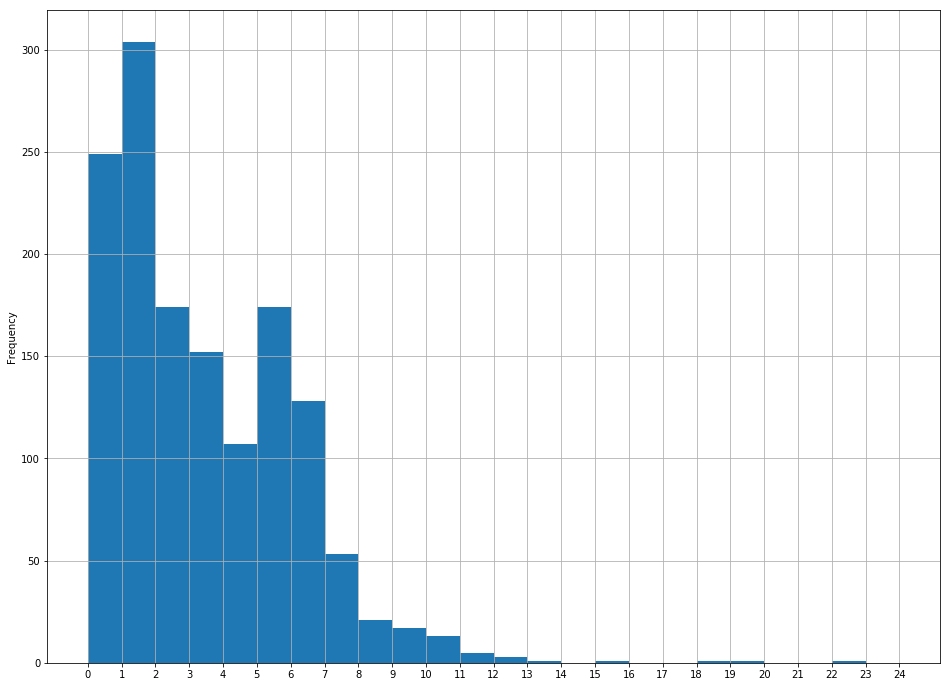

In [37]:
ending = pd.Series(data=[period.last_real_fraction for period in periods])
ending.plot.hist(bins=range(25), figsize=(16,12), xticks=range(25), grid=True)  # Bins should really be 0.0 to 5.0 by 0.1

In [38]:
portfolio = Portfolio(cash_cushion=True, ratchet=True)

(survivability, sustainability,
balance_growth_median, balance_growth_mean, balance_growth_stdev,
withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev,
periods) = portfolio.sim_periods(market_data)

print("survivability:  {:.2%}".format(survivability))
print("sustainability: {:.2%}".format(sustainability))
print("balance     median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(balance_growth_median, balance_growth_mean, balance_growth_stdev))
print("withdrawal  median: {:6.2%}  mean: {:6.2%}  stdev: {:6.2%}".format(withdrawal_growth_median, withdrawal_growth_mean, withdrawal_growth_stdev))


survivability:  98.65%
sustainability: 53.81%
balance     median:  0.18%  mean:  0.01%  stdev:  2.51%
withdrawal  median:  2.05%  mean:  2.28%  stdev:  1.50%


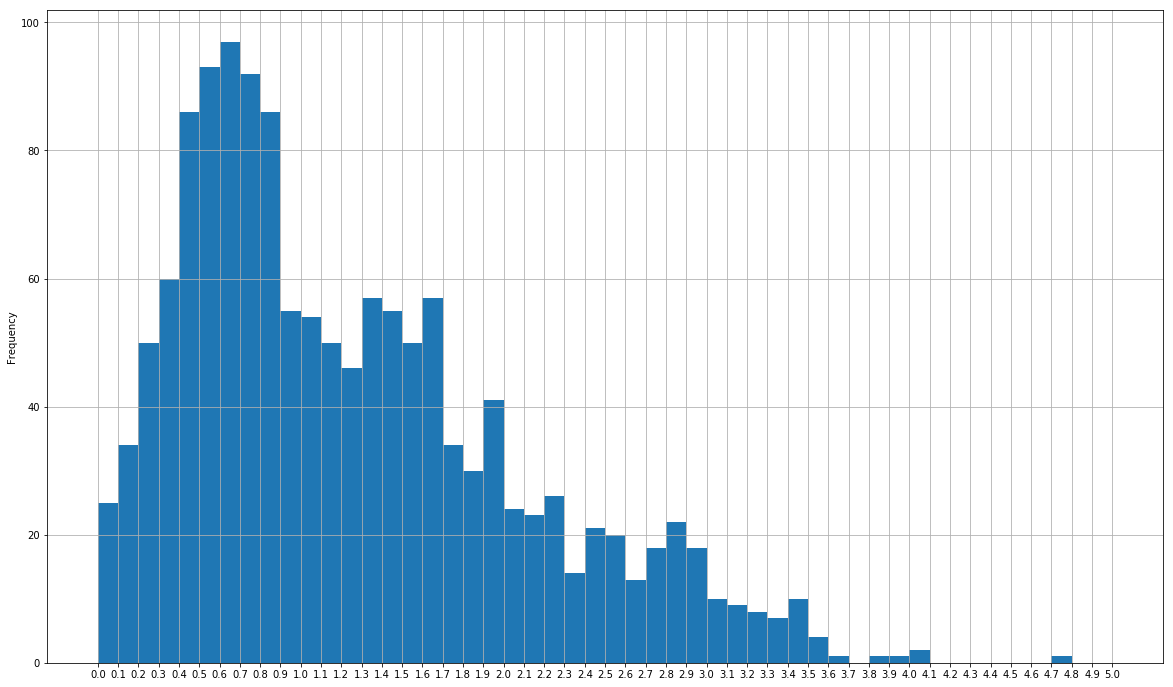

In [39]:
ending = pd.Series(data=[period.last_real_fraction for period in periods])
ending.plot.hist(bins=list(i/10 for i in range(51)), figsize=(20,12), xticks=list(i/10 for i in range(51)), grid=True)  # Bins should really be 0.0 to 5.0 by 0.1

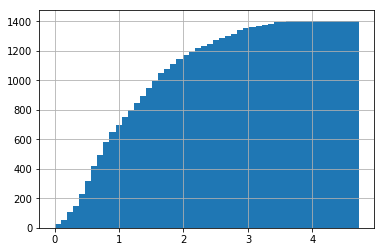

In [40]:
ending = pd.Series(data=[period.last_real_fraction for period in periods])
ending.hist(bins=50, cumulative=True)  # Bins should really be 0.0 to 5.0 by 0.1

What is causing the ending values significantly larger than 1.0?  The ratchet mechanism should have caused withdrawals to increase to drain the portfolio back down to a value equal to the starting value (adjusted for inflation).

Oh, I think I see.  It's because the withdrawal rate (and ratchet_to_rate) stays constant as the time remaining goes to zero.  If the market keeps growing consistently faster than the nominal withdrawal rate, could the portfolio grow like this?

Or is this just keeping in line with the compounding growth of withdrawals?  After all, a larger withdrawal is supported by a larger portfolio balance.  2.28% compounded over 30 years is 96.66% growth (or an ending factor of 1.9666).

**TODO** It would be interesting to look at the non-sustained periods and see how much withdrawals grew.

It would be interesting to plot last_real_fraction vs. withdrawal_rate_real.  It should be sufficient to graph growth_rate_real vs. withdrawal_rate_real.  Probably a scatter plot.

In [41]:
Period._fields

('date',
 'survived',
 'sustained',
 'min_real',
 'max_real',
 'last_real',
 'last_real_fraction',
 'growth_rate_real',
 'withdrawal_rate_real',
 'history')

In [42]:
df = pd.DataFrame.from_records(periods, columns=Period._fields)

In [43]:
df['color'] = 'b'
df.loc[~df.survived, 'color'] = 'r'
df.loc[df.growth_rate_real >= 0.0, 'color'] = 'g'

How do I get it to show a legend for the colors?

I think I would have to do multiple plots using the same axes object

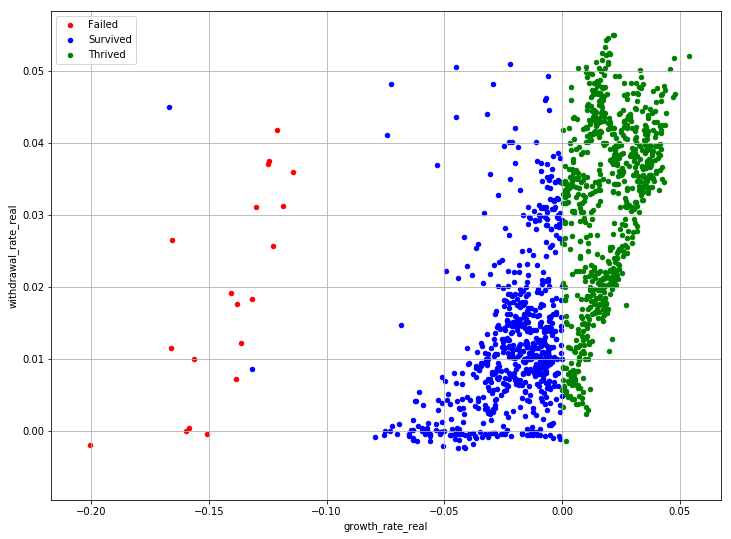

In [44]:
ax = df[df.color == 'r'].plot.scatter(x='growth_rate_real', y='withdrawal_rate_real', figsize=(12,9), grid=True,
                c='r', label='Failed')
ax = df[df.color == 'b'].plot.scatter(x='growth_rate_real', y='withdrawal_rate_real', figsize=(12,9), grid=True,
                ax=ax, c='b', label='Survived')
ax = df[df.color == 'g'].plot.scatter(x='growth_rate_real', y='withdrawal_rate_real', figsize=(12,9), grid=True,
                ax=ax, c='g', label='Thrived')


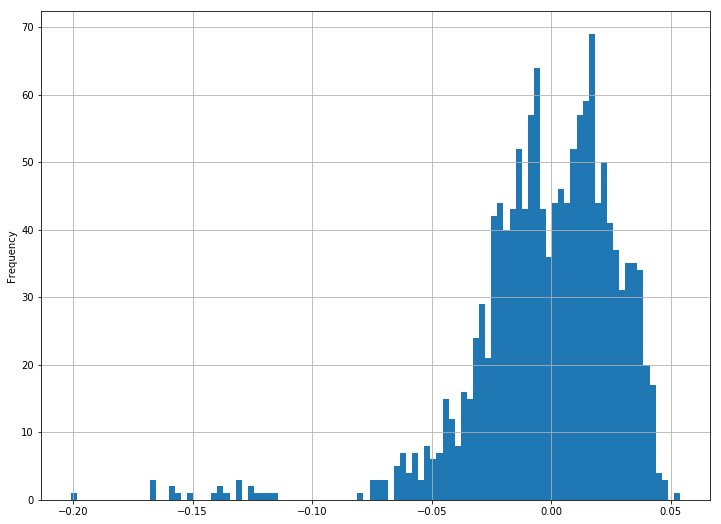

In [45]:
df.growth_rate_real.plot.hist(bins=100, grid=True, figsize=(12,9))

In [46]:
g = df.groupby('color')
h = pd.DataFrame({"Failed": g.get_group('r').growth_rate_real,
                  "Survived": g.get_group('b').growth_rate_real,
                  "Thrived": g.get_group('g').growth_rate_real})

In [47]:
bins = np.linspace(-0.215, 0.055, num=55, endpoint=True)
bins

array([-0.215, -0.21 , -0.205, -0.2  , -0.195, -0.19 , -0.185, -0.18 ,
       -0.175, -0.17 , -0.165, -0.16 , -0.155, -0.15 , -0.145, -0.14 ,
       -0.135, -0.13 , -0.125, -0.12 , -0.115, -0.11 , -0.105, -0.1  ,
       -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065, -0.06 ,
       -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025, -0.02 ,
       -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,
        0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055])

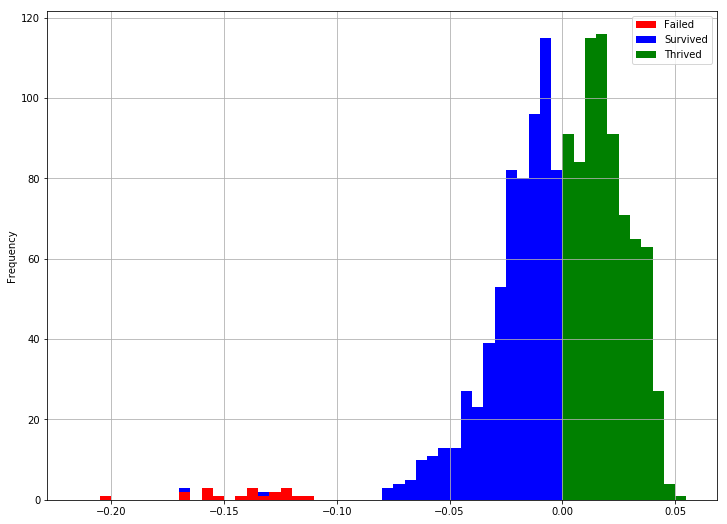

In [48]:
h.plot.hist(bins=bins, figsize=(12,9), grid=True, stacked=True, colormap=matplotlib.colors.ListedColormap(['r', 'b', 'g']))